In [ ]:
hip_lp_ckpt = '/niddk-data-central/leo_workspace/MoCA_result/LP/ckpt/Hip_20epochLP_blr_0.01_bs_256_input_size_[3, 100]/2025-04-27_02-37/checkpoint-best.pth'


In [ ]:
import models_vit
import torch

hip_lp_model = models_vit.__dict__['vit_base_patch16'](
            img_size=[3,100], patch_size=[1, int(5)], 
            num_classes=2, in_chans=1, 
            global_pool=False)
hip_lp_model.head = torch.nn.Sequential(torch.nn.BatchNorm1d(768, affine=False, eps=1e-6), hip_lp_model.head)


/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hip-LP CM

In [3]:
hip_lp_checkpoint = torch.load(hip_lp_ckpt, map_location='cpu')['model']
if any(k.startswith("module.") for k in hip_lp_checkpoint.keys()):
    hip_lp_checkpoint = {k.replace("module.", ""): v for k, v in hip_lp_checkpoint.items()}
    
hip_lp_model.load_state_dict(hip_lp_checkpoint, strict=True)


<All keys matched successfully>

In [47]:
from util.datasets import iWatch_HDf5,collate_fn

def get_loader(data_path,subset=None):
    if subset is not None:
        dataset_val = iWatch_HDf5(data_path, set_type='val', transform=None,subset=subset)
        sampler_val = torch.utils.data.SequentialSampler(dataset_val)
    else:
        dataset_val = iWatch_HDf5(data_path, set_type='val', transform=None)
        sampler_val = torch.utils.data.SequentialSampler(dataset_val)

    data_loader_val = torch.utils.data.DataLoader(
            dataset_val,
            sampler = sampler_val,
            batch_size=1024,
            num_workers=2,
            pin_memory=True,
            drop_last=False,
            persistent_workers=True,
            collate_fn = collate_fn)

    return data_loader_val

hip_loader = get_loader('/niddk-data-central/iWatch/pre_processed_seg/H')

In [30]:
from itertools import chain
from tqdm import tqdm
import numpy as np
from sklearn.metrics import balanced_accuracy_score

def mae_classification_pass(data_loader, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # ensures dropout etc. is disabled
    print('using', device)

    # Use flat Python lists
    preds_list = []
    targets_list = []

    # no gradient needed
    for batch in tqdm(data_loader):
        images = batch[0].to(device, non_blocking=True)
        target = batch[-1].to(device, non_blocking=True)
        
        with torch.no_grad():
            output = model(images)
        pred = torch.argmax(output, dim=1)

        preds_list.extend(pred.cpu().tolist())
        targets_list.extend(target.cpu().tolist())

    balanced_acc = balanced_accuracy_score(targets_list, preds_list)
    return preds_list, targets_list, balanced_acc


In [31]:
def plot_cm(cm_all, title, labels=['Sitting', 'Non-Sitting']):
    fig, ax = plt.subplots(figsize=(6, 5))  # use object-oriented API

    sns.heatmap(
        cm_all,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels,
        annot_kws={"size": 20},
        cbar=False,
        linewidths=0.2,
        linecolor='white',
        ax=ax
    )
    ax.set_title(title, fontsize=20)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    fig.tight_layout()

    return fig


using cuda


100%|██████████| 386/386 [15:40<00:00,  2.44s/it]


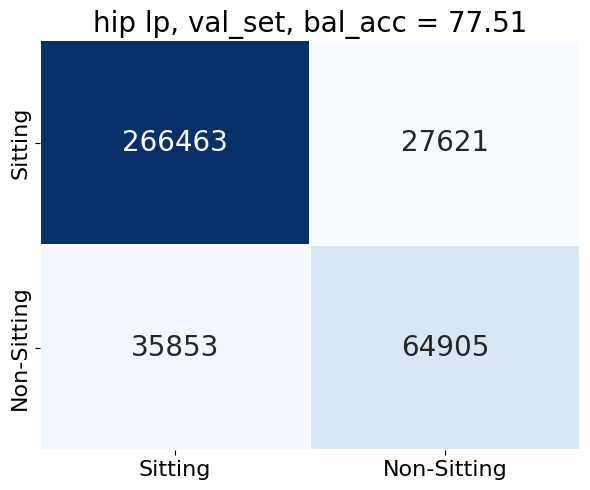

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pred_all, target_all, accuracy_all = mae_classification_pass(hip_loader,hip_lp_model)
trial_classification = f'hip lp, val_set, bal_acc = {accuracy_all*100:.2f}'
cm_all = confusion_matrix(target_all, pred_all)

cm_plt = plot_cm(cm_all,trial_classification)


In [ ]:
# # Add to wandb
import wandb
wandb.login(key='32b6f9d5c415964d38bfbe33c6d5c407f7c19743')
run = wandb.init(project='MoCA-iWatch-LP', id='e7r262yh', resume='allow')
wandb.log({"confusion_matrix": wandb.Image(cm_plt)})
run.finish()get_loader

# Wrist LP

In [40]:
wrist_lp_ckpt = '/niddk-data-central/leo_workspace/MoCA_result/LP/ckpt/Wrist_20epochblr_0.01_bs_256_input_size_[3, 100]/2025-04-26_20-00/checkpoint-best.pth'

wrist_lp_model = models_vit.__dict__['vit_base_patch16'](
            img_size=[3,100], patch_size=[1, int(5)], 
            num_classes=2, in_chans=1, 
            global_pool=False)
            
wrist_lp_model.head = torch.nn.Sequential(torch.nn.BatchNorm1d(768, affine=False, eps=1e-6), wrist_lp_model.head)

wrist_lp_checkpoint = torch.load(wrist_lp_ckpt, map_location='cpu')['model']
if any(k.startswith("module.") for k in wrist_lp_checkpoint.keys()):
    wrist_lp_checkpoint = {k.replace("module.", ""): v for k, v in wrist_lp_checkpoint.items()}
wrist_lp_model.load_state_dict(wrist_lp_checkpoint, strict=True)

<All keys matched successfully>

In [ ]:
wrist_loader = get_loader('/niddk-data-central/iWatch/pre_processed_seg/W',subset=4096)
wrist_pred_all, wrist_target_all, wrisst_accuracy_all = mae_classification_pass(wrist_loader,wrist_lp_model)
trial_classification = f'wrist lp, sample size 4096, bal_acc = {accuracy_all*100:.2f}'
wrist_cm_all = confusion_matrix(wrist_target_all, wrist_pred_all)

wrist_cm_plt = plot_cm(wrist_cm_all,trial_classification)

using cuda


 25%|██▌       | 1/4 [00:07<00:23,  7.87s/it]

In [ ]:
run = wandb.init(project='MoCA-iWatch-LP', id='j4gvl2vd', resume='allow')
wandb.log({"confusion_matrix": wandb.Image(wrist_cm_plt)})
run.finish()

# Attention Probe

In [ ]:
from main_attnprobe import AttentionProbeModel
sys.path.append('/DeepPostures_MAE/MSSE-2021-pt')
from commons import get_dataloaders

def get_iterloader(data_path):
    with open("/niddk-data-central/iWatch/support_files/iwatch_split_dict.pkl", "rb") as f:
            split_data = pickle.load(f)

        train_subjects = split_data["train"]
        valid_subjects = split_data["val"]
        

        #random.shuffle(train_subjects)
        random.shuffle(valid_subjects)

        _, val_loader, _ = get_dataloaders(
        pre_processed_dir=data_path,
        bi_lstm_win_size=42,
        batch_size=4,
        train_subjects=train_subjects,
        valid_subjects=valid_subjects,
        test_subjects=None,
    )

    return val_loader